In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.vq import whiten
from sklearn.cluster import KMeans

# Read data and quiality check

In [2]:
data = pd.read_csv('Country-data.csv')

In [3]:
data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [4]:
data.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

In [5]:
country = data.country
data2 = data.drop('country', axis=1)
col = data2.columns

### Removing outliers

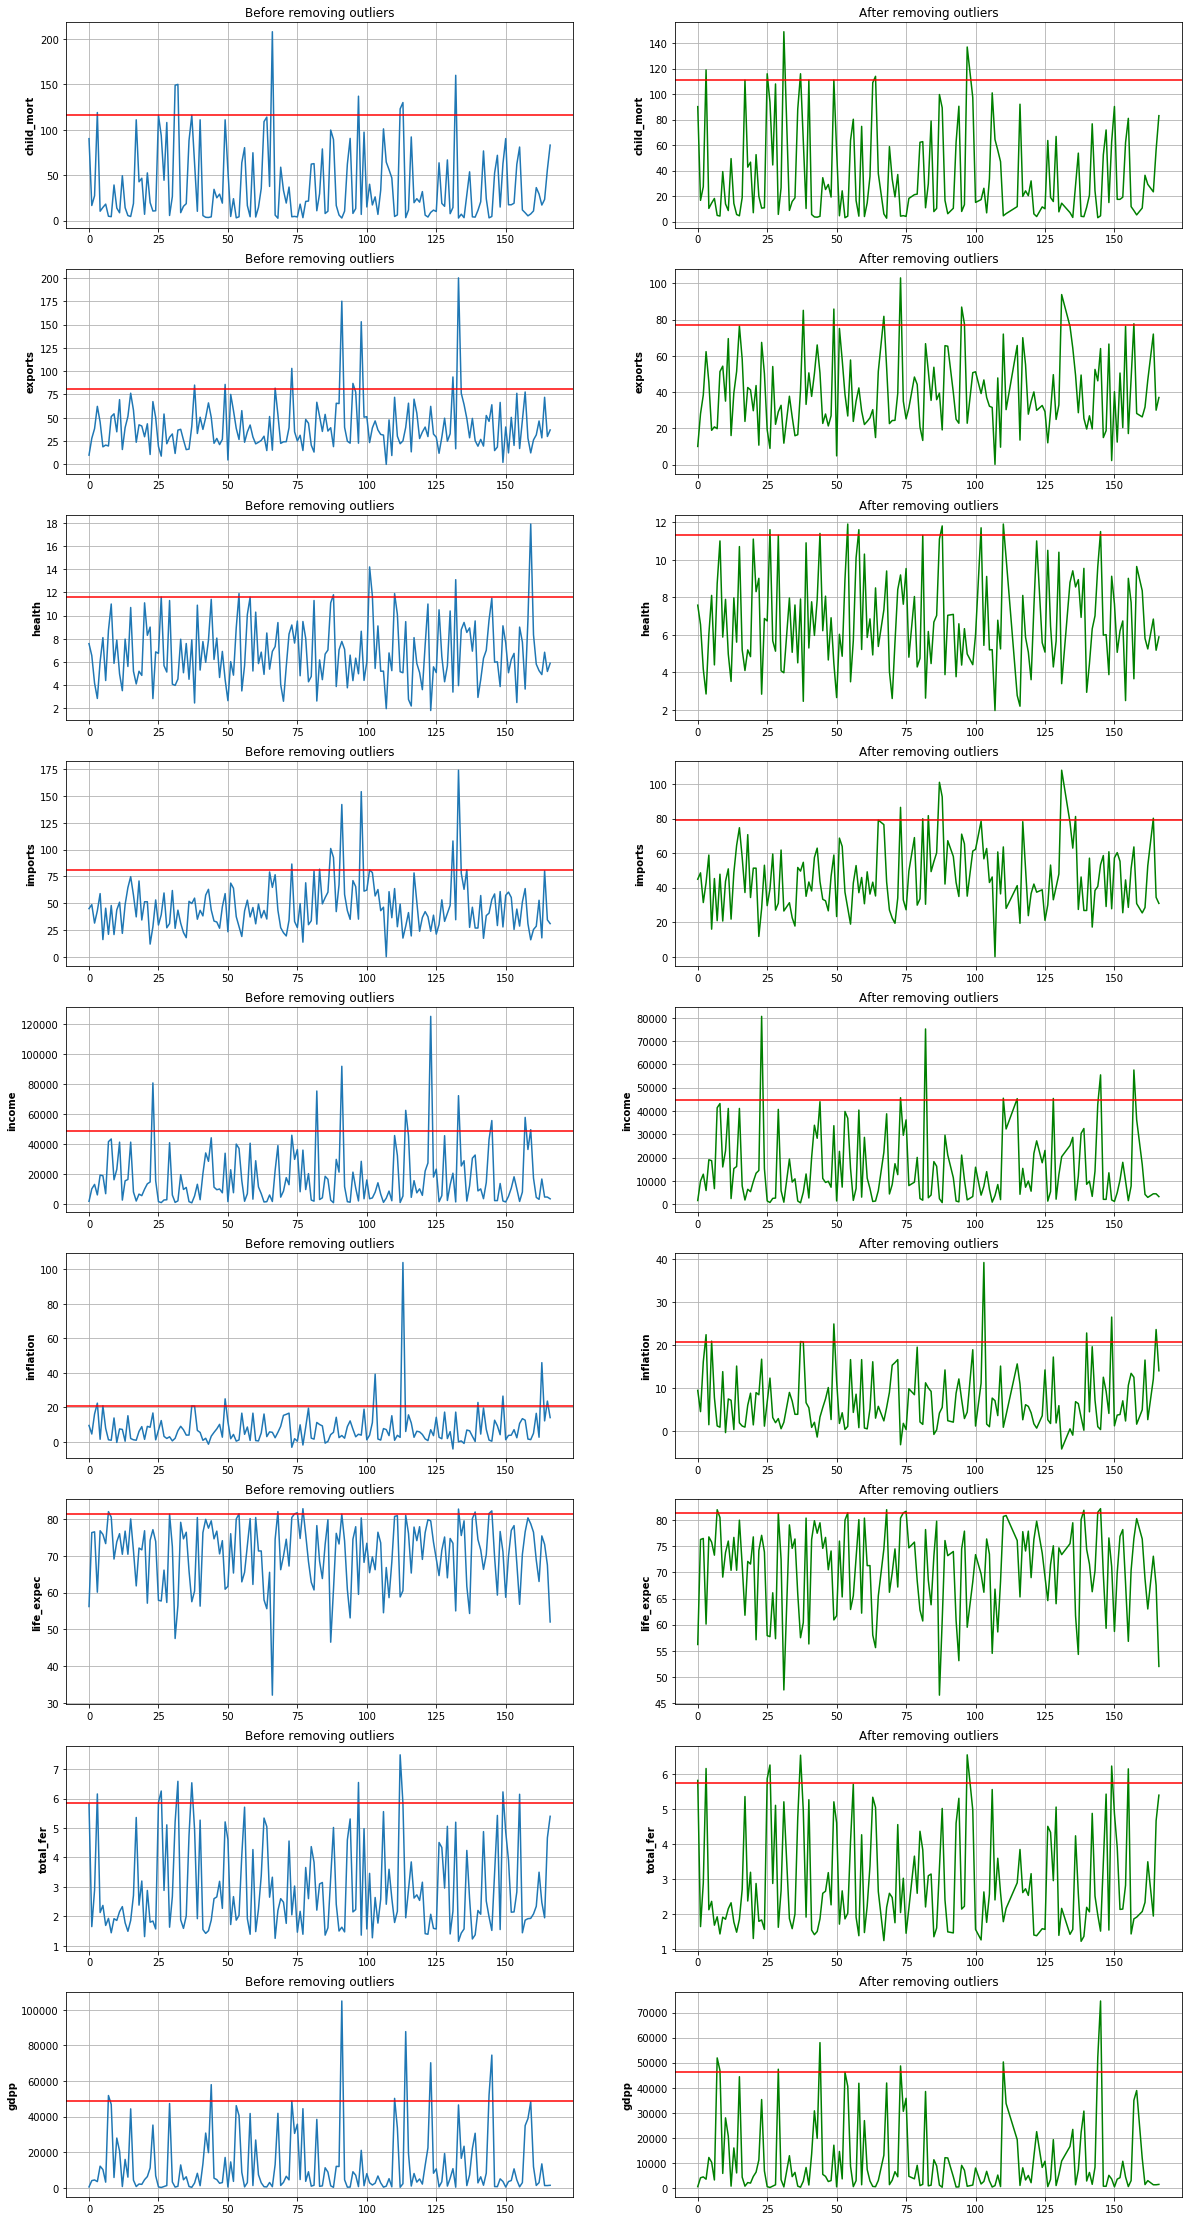

In [6]:
plt.rcParams["figure.figsize"] = (20,40)

indexes = []
for j, i in enumerate(data2):
    indexes.append(data2.loc[data2[i]>data2[i].quantile(0.99)].index)

indexes = np.unique(indexes)
df = data2.drop(indexes, axis=0, inplace=False)

f, axs = plt.subplots(9, 2)
for j, i in enumerate(df): 
    axs[j,0].set_title('Before removing outliers')
    axs[j,0].plot(data2[i])
    axs[j,0].set_ylabel(i, fontweight ='bold') 
    axs[j,0].axhline(y=data2[i].quantile(0.95), color='r', linestyle='-')
    axs[j,0].grid()
    
    axs[j,1].set_title('After removing outliers')
    axs[j,1].plot(df[i], color='g')
    axs[j,1].set_ylabel(i, fontweight ='bold') 
    axs[j,1].axhline(y=df[i].quantile(0.95), color='r', linestyle='-')
    axs[j,1].grid()

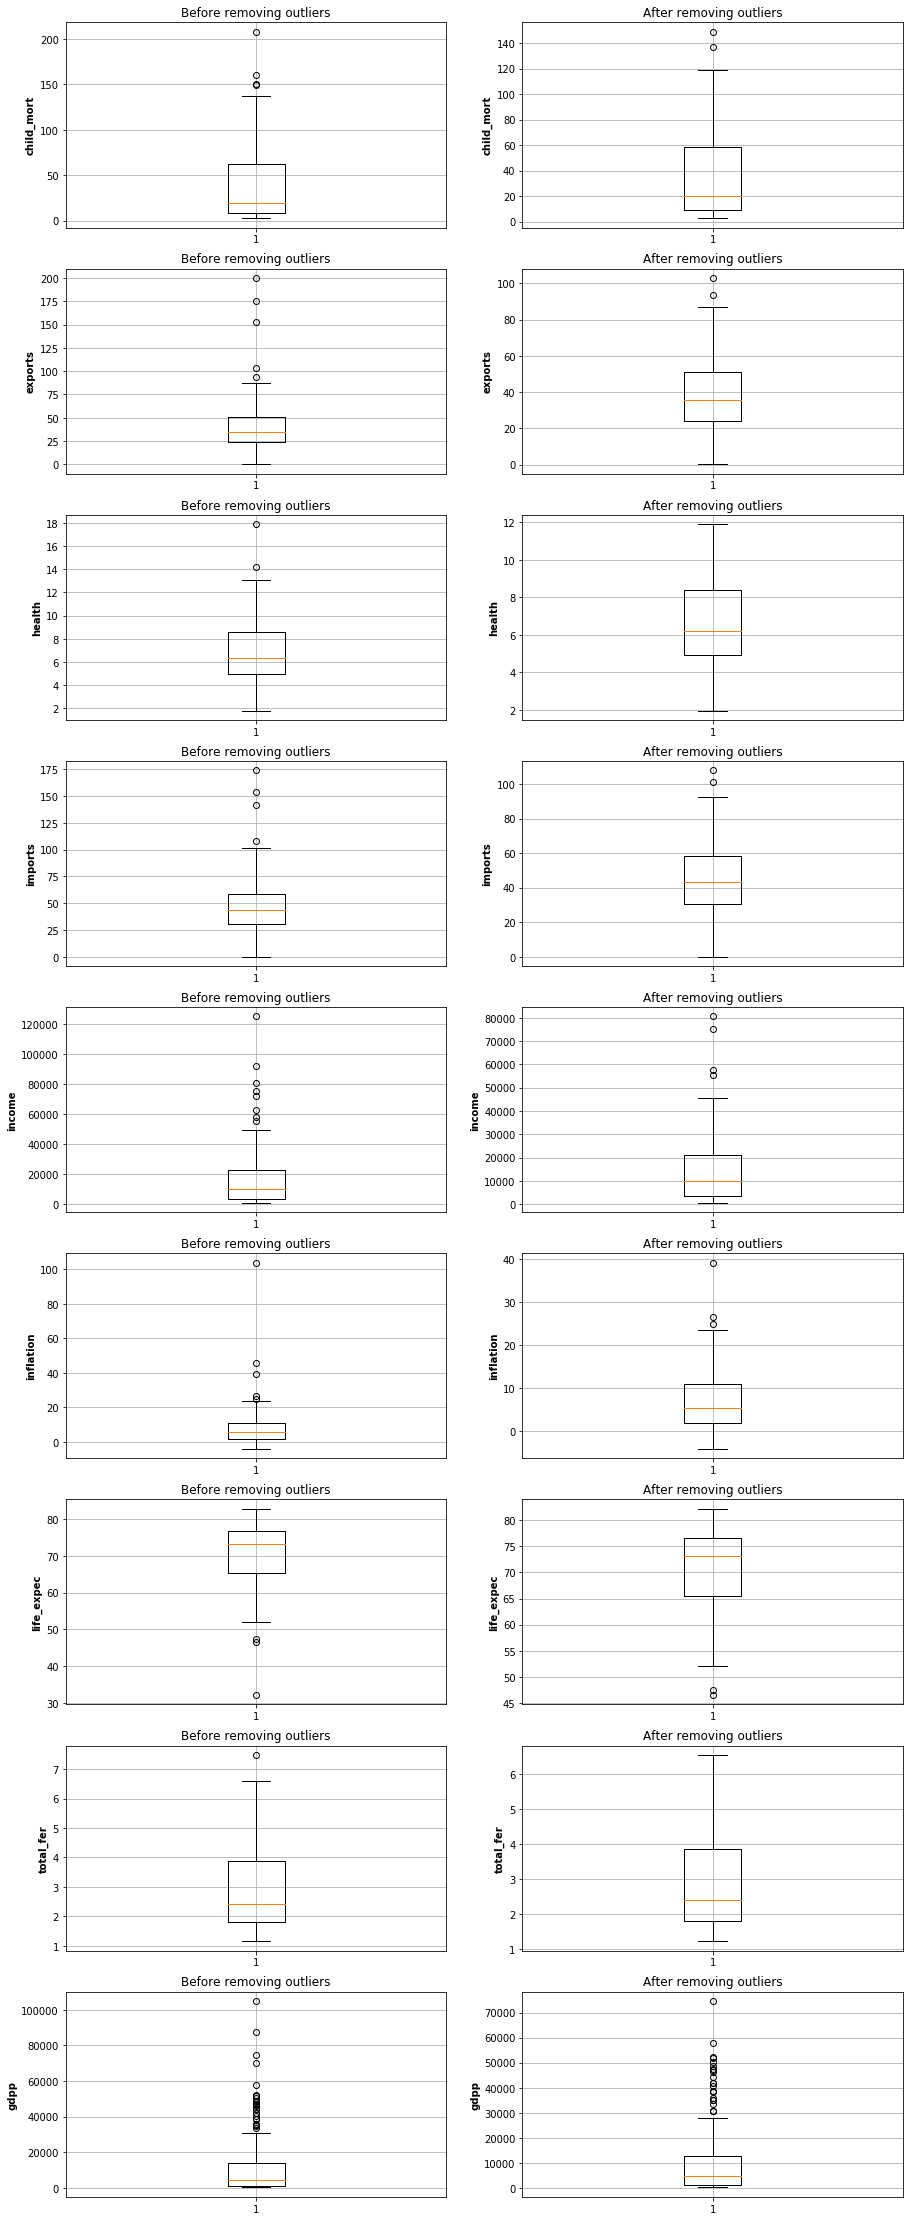

In [7]:
plt.rcParams["figure.figsize"] = (15,40)

f, axs = plt.subplots(9, 2)

for j, i in enumerate(data2): 
    axs[j,0].set_title('Before removing outliers')
    axs[j,0].boxplot(data2[i])
    axs[j,0].set_ylabel(i, fontweight ='bold') 
    axs[j,0].grid()
    axs[j,1].set_title('After removing outliers')
    axs[j,1].boxplot(df[i])
    axs[j,1].set_ylabel(i, fontweight ='bold') 
    axs[j,1].grid()


### Correlataion check

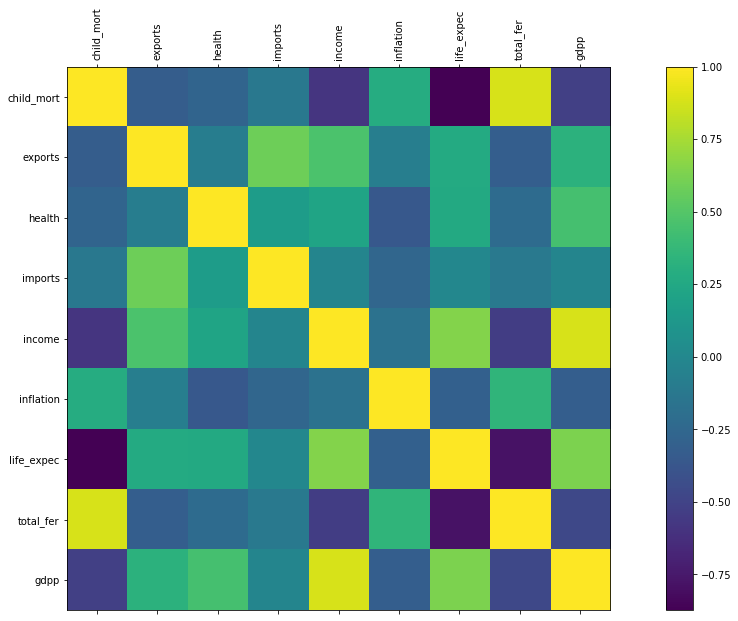

In [8]:
plt.rcParams["figure.figsize"] = (20,10)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(df.corr())
fig.colorbar(cax)
ax.set_xticks(np.arange(len(col)))
ax.set_xticklabels(col, rotation=90)
ax.set_yticks(np.arange(len(col)))
ax.set_yticklabels(col);

,child_mort,life_expec
child_mort,1.000000,-0.873447
life_expec,-0.873447,1.000000


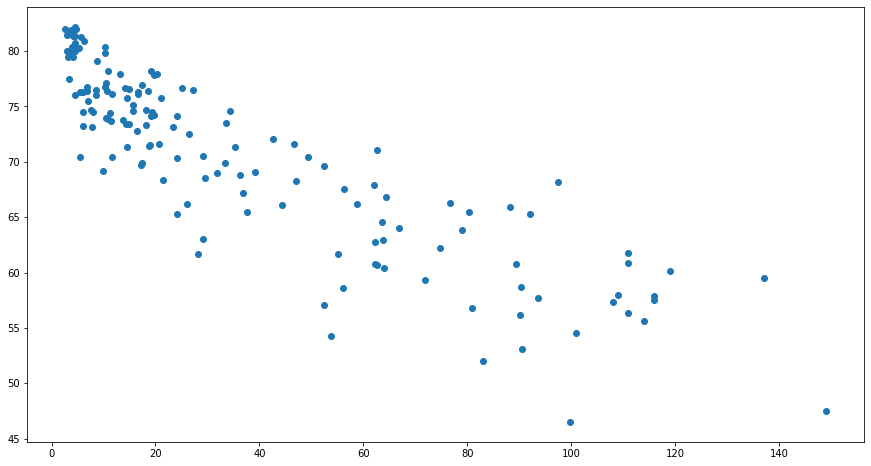

In [13]:
plt.rcParams["figure.figsize"] = (15,8)

plt.scatter(df.child_mort, df.life_expec)
df[['child_mort', 'life_expec']].corr()

,income,gdpp
income,1.000000,0.886635
gdpp,0.886635,1.000000


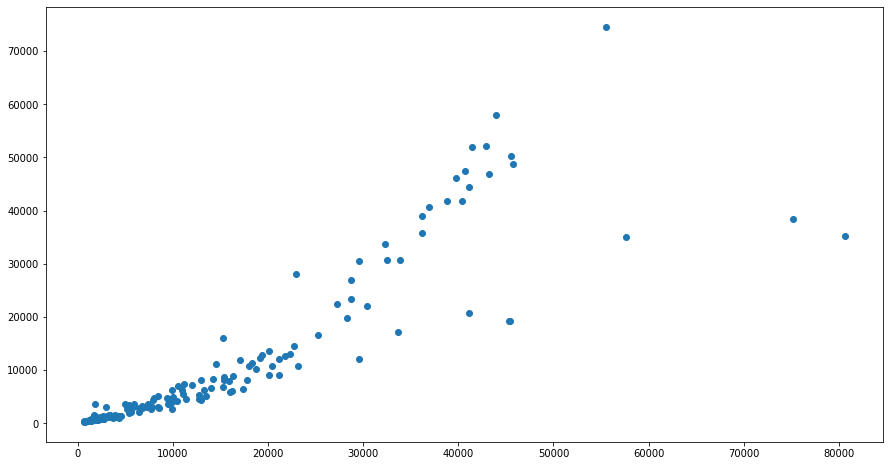

In [14]:
plt.scatter(df.income, df.gdpp)
df[['income', 'gdpp']].corr()

,child_mort,total_fer
child_mort,1.000000,0.883736
total_fer,0.883736,1.000000


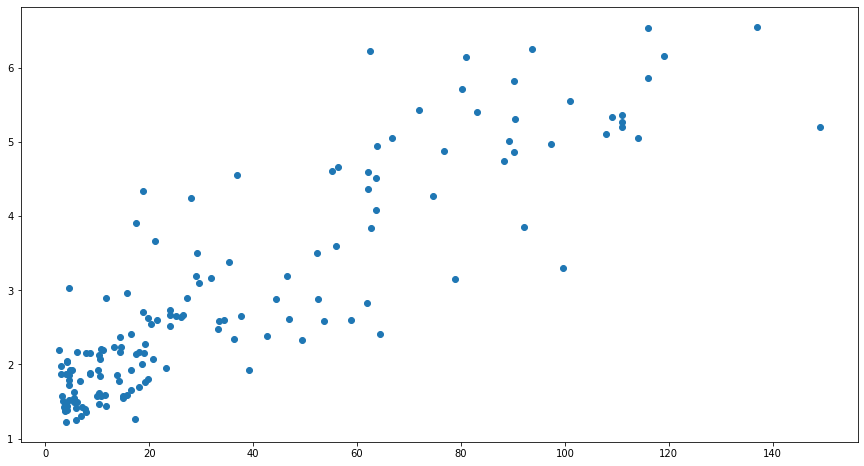

In [15]:
plt.scatter(df.child_mort, df.total_fer)
df[['child_mort', 'total_fer']].corr()

In [16]:
# Remove strongly correlated factors
df.drop('income', axis=1, inplace=True)
df.drop('life_expec', axis=1, inplace=True)
df.drop('total_fer', axis=1, inplace=True)

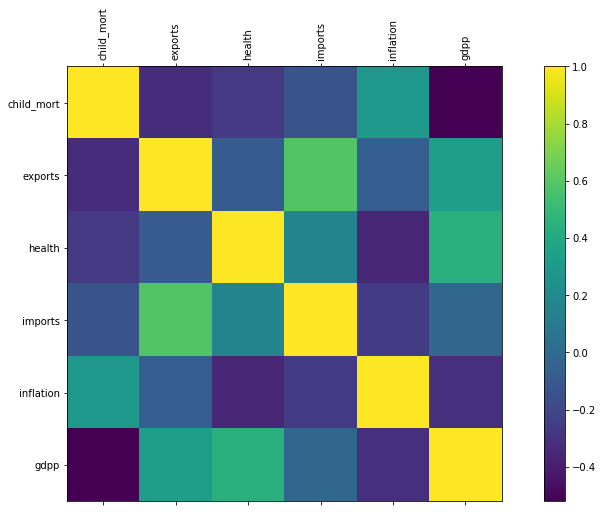

In [17]:
col = df.columns

fig = plt.figure()
ax = fig.add_subplot(111)
plt.rcParams["figure.figsize"] = (20,10)
cax = ax.matshow(df.corr())
fig.colorbar(cax)
ax.set_xticks(np.arange(len(col)))
ax.set_xticklabels(col, rotation=90)
ax.set_yticks(np.arange(len(col)))
ax.set_yticklabels(col);

# Fit models

### Hierarchical clustering

In [18]:
# Scale data and use hierarchical clustering
scaled_features = whiten(df)
mergings = linkage(scaled_features, method='complete')

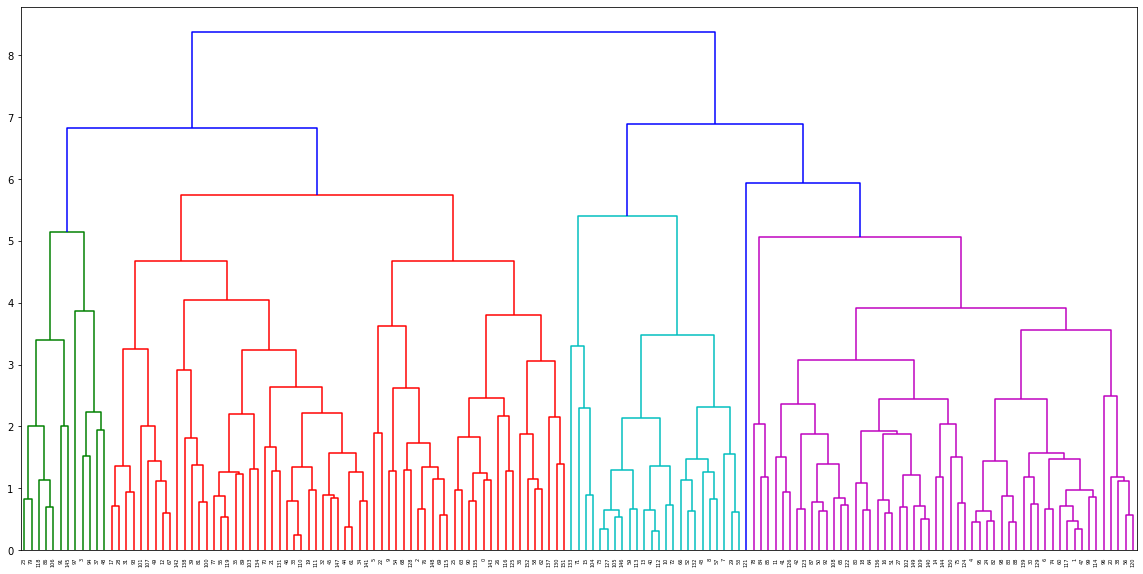

In [19]:
#  Illustratehow how clusters are created
dendrogram(mergings)
plt.show()

In [20]:
# Form clusters from the hierarchical clustering 
labels = fcluster(mergings, 6.85, criterion='distance')
np.unique(labels)

array([1, 2, 3], dtype=int32)

In [21]:
# Compare results with kaggle results
HR = pd.read_csv('Hierchical_Results.csv')
HR2 = HR.drop(indexes, axis=0, inplace=False)
pd.crosstab(labels, HR2.Hier_Clusters)

Hier_Clusters,0,1,2
row_0,,,
1,6,46,23
2,20,4,0
3,1,53,0


In [22]:
pairs = pd.DataFrame({'Country': country.drop(indexes, axis=0), 'Label': labels})
n = len(np.unique(pairs.Label))
pairs.head()

,Country,Label
0,Afghanistan,1
1,Albania,3
2,Algeria,1
3,Angola,1
4,Antigua and Barbuda,3


# K-means

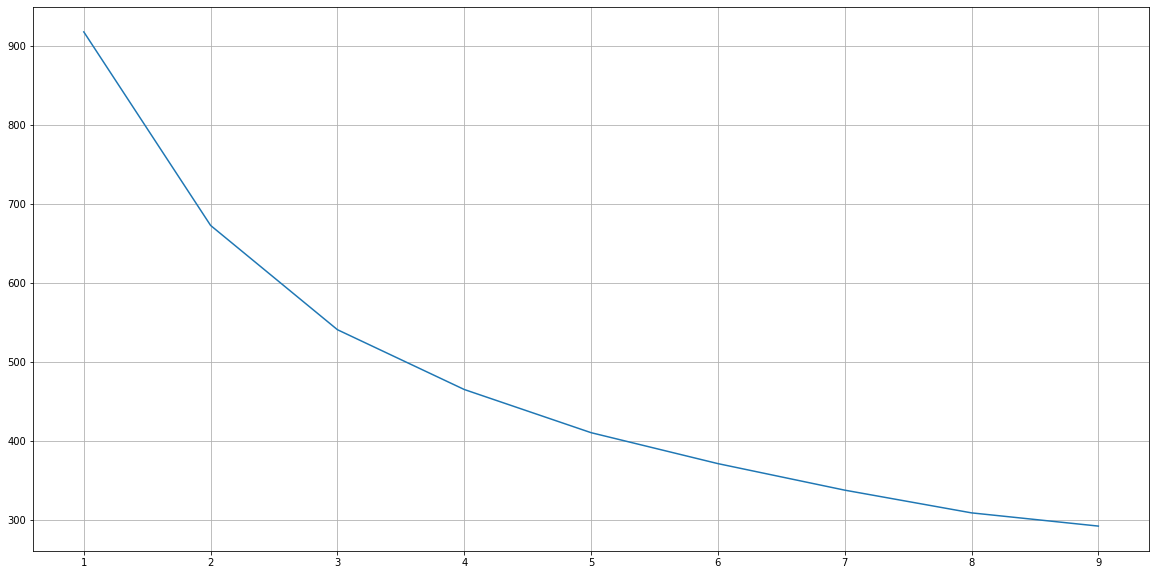

In [23]:
inertia = []
for i in np.arange(1,10):
    km = KMeans(n_clusters=i)
    km.fit(scaled_features)
    inertia = np.append(inertia, km.inertia_)

plt.plot(np.arange(1,10), inertia)
plt.grid() 

In [24]:
# Instantiate kmeans model
km = KMeans(n_clusters=3)
# Train the model
km.fit(scaled_features)
# Predict label
label_km = km.predict(scaled_features)
pairs['Label_km'] = label_km

# Compare results with kaggle results
KM = pd.read_csv('KMeans_results.csv')
KM2 = KM.drop(indexes, axis=0, inplace=False)
pd.crosstab(label_km, KM2.KM_Clusters)

KM_Clusters,0,1,2
row_0,,,
0,52,6,8
1,29,36,1
2,1,0,20


Text(0.5, 0, 'HEALTH')

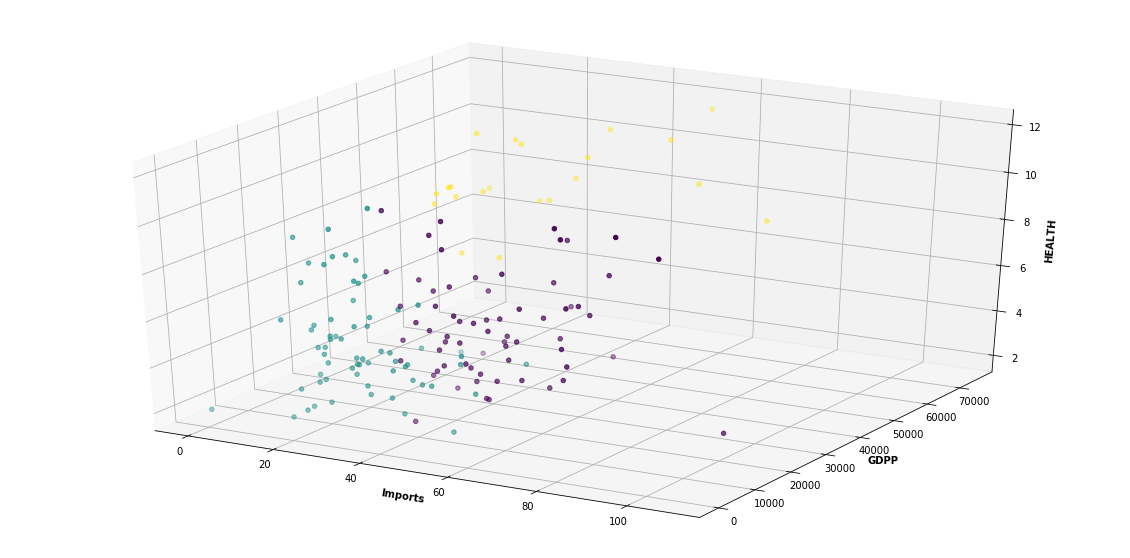

In [25]:
# Ilustrate results on the graph
fig = plt.figure()
ax = plt.axes(projection='3d')
ys = df.gdpp
xs = df.imports
zs = df.health

ax.scatter3D(xs, ys, zs, c=label_km)
ax.set_xlabel('Imports', fontweight ='bold') 
ax.set_ylabel('GDPP', fontweight ='bold') 
ax.set_zlabel('HEALTH', fontweight ='bold')

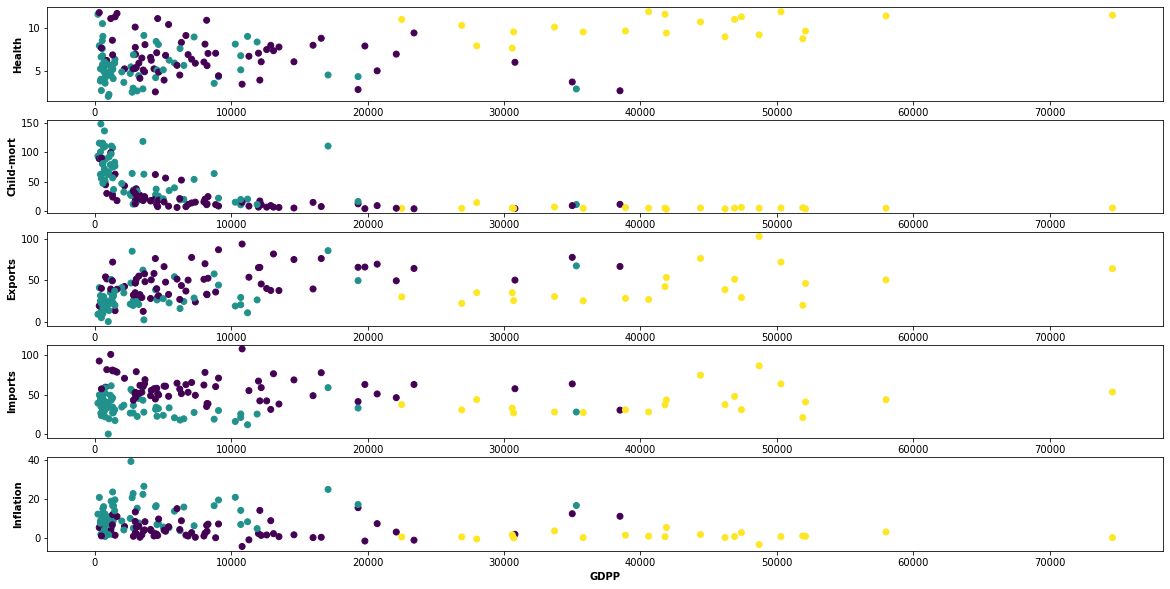

In [26]:
# Ilustrate results on the graphs
f, axs = plt.subplots(5)
xs = df.gdpp
ys1 = df.health
ys2 = df.child_mort
ys3 = df.exports
ys5 = df.imports
ys6 = df.inflation


axs[0].scatter(xs, ys1, c=label_km)
axs[0].set_ylabel('Health', fontweight ='bold') 
axs[0].set_xlabel('GDPP', fontweight ='bold') 

axs[1].scatter(xs, ys2, c=label_km)
axs[1].set_ylabel('Child-mort', fontweight ='bold') 
axs[1].set_xlabel('GDPP', fontweight ='bold') 

axs[2].scatter(xs, ys3, c=label_km)
axs[2].set_ylabel('Exports', fontweight ='bold') 
axs[2].set_xlabel('GDPP', fontweight ='bold') 

axs[3].scatter(xs, ys5, c=label_km)
axs[3].set_ylabel('Imports', fontweight ='bold') 
axs[3].set_xlabel('GDPP', fontweight ='bold')

axs[4].scatter(xs, ys6, c=label_km)
axs[4].set_ylabel('Inflation', fontweight ='bold') 
axs[4].set_xlabel('GDPP', fontweight ='bold');

